# Long-Short Strategy, Part 2: Trading signals with LightGBM and CatBoost

In this section, we'll start designing, implementing, and evaluating a trading strategy for US equities driven by daily return forecasts produced by gradient boosting models.

As in the previous examples, we'll lay out a framework and build a specific example that you can adapt to run your own experiments. There are numerous aspects that you can vary, from the asset class and investment universe to more granular aspects like the features, holding period, or trading rules. See, for example, the **Alpha Factor Library** in the [Appendix](../24_alpha_factor_library) for numerous additional features.

We'll keep the trading strategy simple and only use a single ML signal; a real-life application will likely use multiple signals from different sources, such as complementary ML models trained on different datasets or with different lookahead or lookback periods. It would also use sophisticated risk management, from simple stop-loss to value-at-risk analysis.

**Six notebooks** cover our workflow sequence:

1. [preparing_the_model_data](04_preparing_the_model_data.ipyny): we engineer a few simple features from the Quandl Wiki data 
2. `trading_signals_with_lightgbm_and_catboost`  (this noteboook): we tune hyperparameters for LightGBM and CatBoost to select a model, using 2015/16 as our validation period. 
3. [evaluate_trading_signals](06_evaluate_trading_signals.ipynb): we compare the cross-validation performance using various metrics to select the best model. 
4. [model_interpretation](07_model_interpretation.ipynb): we take a closer look at the drivers behind the best model's predictions.
5. [making_out_of_sample_predictions](08_making_out_of_sample_predictions.ipynb): we generate predictions for our out-of-sample test period 2017.
6. [backtesting_with_zipline](09_backtesting_with_zipline.ipynb): evaluate the historical performance of a long-short strategy based on our predictive signals using Zipline.

We'll subset the dataset created in the preceding notebook through the end of 2016 to cross-validate several model configurations for various lookback and lookahead windows, as well as different roll-forward periods and hyperparameters. 

Our approach to model selection will be similar to the one we used in the previous chapter and uses the custom `MultipleTimeSeriesCV` introduced in [Chapter 7, Linear Models – From Risk Factors to Return Forecasts](../07_linear_models).

## Imports & Settings

In [157]:
import warnings
warnings.filterwarnings('ignore')

In [158]:
%matplotlib inline

from pathlib import Path
import sys, os
from time import time
from tqdm import tqdm

from collections import defaultdict
from itertools import product

import numpy as np
import pandas as pd

import lightgbm as lgb
from catboost import Pool, CatBoostRegressor

from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

from alphalens.tears import (create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens.utils import get_clean_factor_and_forward_returns

import matplotlib.pyplot as plt
import seaborn as sns

In [159]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV, format_time

In [160]:
sns.set_style('whitegrid')

In [161]:
YEAR = 252
idx = pd.IndexSlice

## Get Data

We select the train and validation sets, and identify labels and features:

In [162]:
data = (pd.read_hdf('data.h5', 'model_data')
            .sort_index()
            .loc[idx[:, :'2022'], :]) # train & validation period
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 111185 entries, ('ALUA.BA', Timestamp('2010-01-04 00:00:00')) to ('YPFD.BA', Timestamp('2020-12-30 00:00:00'))
Data columns (total 22 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   dollar_vol       111185 non-null  float64
 1   dollar_vol_rank  111185 non-null  float64
 2   rsi              110583 non-null  float64
 3   bb_high          110368 non-null  float64
 4   bb_low           110366 non-null  float64
 5   NATR             110583 non-null  float64
 6   ATR              110583 non-null  float64
 7   ppo              110110 non-null  float64
 8   MACD             109766 non-null  float64
 9   sector           111185 non-null  int64  
 10  r01              111142 non-null  float64
 11  r05              110970 non-null  float64
 12  r10              110755 non-null  float64
 13  r21              110282 non-null  float64
 14  r42              109379 non-null  float64
 15  r6

In [163]:
labels = sorted(data.filter(like='_fwd').columns)
features = data.columns.difference(labels).tolist() # features are columns not containing '_fwd'

## Model Selection: Lookback, lookahead and roll-forward periods

In [164]:
tickers = data.index.get_level_values('symbol').unique()

We may want to predict 1, 5 or 21-day returns:

In [165]:
lookaheads = [1, 5, 21]
# lookaheads = [21]

In [166]:
categoricals = ['year', 'month', 'sector', 'weekday']

We select 4.5 and one years as the length of our training periods; test periods are one and three months long. Since we are using two years (2015/16) for validation, a one-month test period implies 24 folds.

In [167]:
train_lengths = [int(4.5 * 252), 252]
test_lengths = [63, 21]

In [168]:
test_params = list(product(lookaheads, train_lengths, test_lengths))

In [169]:
results_path = Path('results', 'us_stocks')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Baseline: Linear Regression

We always want to know how much our (gradient boosting) is improving over a simpler baseline (if at all..).

In [170]:
lr = LinearRegression()

In [171]:
lr_metrics = []

# iterate over our three CV configuration parameters
for lookahead, train_length, test_length in tqdm(test_params):
    label = f'r{lookahead:02}_fwd'
    df = pd.get_dummies(data.loc[:, features + [label]].dropna(), 
                        columns=categoricals, 
                        drop_first=True)
    X, y = df.drop(label, axis=1), df[label]

    n_splits = int(2 * YEAR / test_length)
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              test_period_length=test_length,
                              lookahead=lookahead,
                              train_period_length=train_length)

    ic, preds = [], []
    for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        preds.append(y_test.to_frame('y_true').assign(y_pred=y_pred))
        ic.append(spearmanr(y_test, y_pred)[0])
    preds = pd.concat(preds)
    lr_metrics.append([lookahead, 
                       train_length, 
                       test_length,
                       np.mean(ic),
                       spearmanr(preds.y_true, preds.y_pred)[0]
                      ])

columns = ['lookahead', 'train_length', 'test_length', 'ic_by_day', 'ic']
lr_metrics = pd.DataFrame(lr_metrics, columns=columns)

  0%|          | 0/12 [00:00<?, ?it/s]

---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}


  8%|▊         | 1/12 [00:01<00:11,  1.04s/it]

---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}


 25%|██▌       | 3/12 [00:02<00:07,  1.17it/s]

---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}


 33%|███▎      | 4/12 [00:03<00:06,  1.32it/s]

---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}


 42%|████▏     | 5/12 [00:04<00:04,  1.50it/s]

---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}


 58%|█████▊    | 7/12 [00:05<00:03,  1.32it/s]

---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}


### Information Coefficient - Distribution by Lookahead

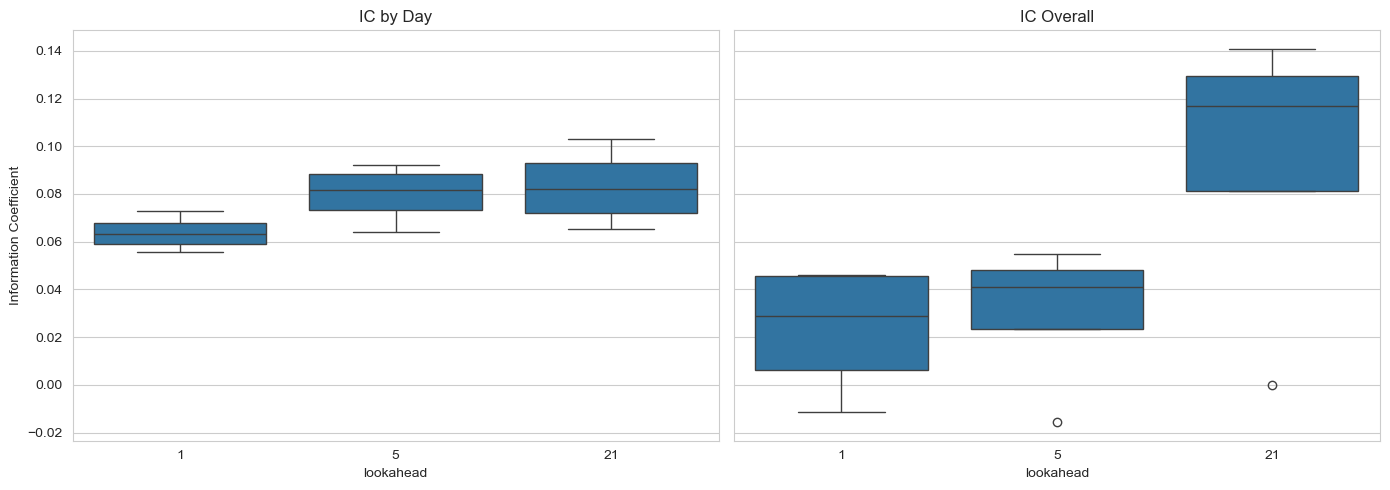

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5), sharey=True)

# plot average of daily IC values
sns.boxplot(x='lookahead', y='ic_by_day',data=lr_metrics, ax=axes[0])
axes[0].set_title('IC by Day')

# plot IC across all predictions
sns.boxplot(x='lookahead', y='ic',data=lr_metrics, ax=axes[1])
axes[1].set_title('IC Overall')
axes[0].set_ylabel('Information Coefficient')
axes[1].set_ylabel('')
fig.tight_layout()

### Best Train/Test Period Lengths

For one- and five-day return forecasts, shorter train- and test-length yield better results in terms of daily avg IC:

In [ ]:
(lr_metrics.groupby('lookahead', group_keys=False)
 .apply(lambda x: x.nlargest(3, 'ic_by_day')))

,lookahead,train_length,test_length,ic_by_day,ic
1,1,1134,21,0.072978,0.045205
0,1,1134,63,0.066265,0.046076
2,1,252,63,0.059931,-0.011535
7,5,252,21,0.092171,0.055000
6,5,252,63,0.087214,-0.015598
5,5,1134,21,0.076497,0.036405
11,21,252,21,0.102942,0.000084
8,21,1134,63,0.089641,0.140778
10,21,252,63,0.074136,0.125806


In [ ]:
lr_metrics.to_csv(results_path / 'lin_reg_metrics.csv', index=False)

## LightGBM Model Tuning

The notebook example iterates over many configurations, optionally using random samples to speed up model selection using a diverse subset. The goal is to identify the most impactful parameters without trying every possible combination.

In [ ]:
def get_fi(model):
    """Return normalized feature importance as pd.Series"""
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

### Hyperparameter Options

The `base_params` are not affected by cross-validation:

In [ ]:
base_params = dict(boosting='gbdt',
                   objective='regression',
                   verbose=-1)

We choose the following parameters and values to select our best model (see book chapter for detail):

In [ ]:
# constraints on structure (depth) of each tree
max_depths = [2, 3, 5, 7]
num_leaves_opts = [2 ** i for i in max_depths]
min_data_in_leaf_opts = [250, 500, 1000]

# weight of each new tree in the ensemble
learning_rate_ops = [.01, .1, .3]

# random feature selection
feature_fraction_opts = [.3, .6, .95]

In [ ]:
param_names = ['learning_rate', 'num_leaves',
               'feature_fraction', 'min_data_in_leaf']

In [ ]:
cv_params = list(product(learning_rate_ops,
                         num_leaves_opts,
                         feature_fraction_opts,
                         min_data_in_leaf_opts))
n_params = len(cv_params)
print(f'# Parameters: {n_params}')

# Parameters: 108


### Train/Test Period Lengths

In [ ]:
lookaheads = [1, 5, 21]
# lookaheads = [21]
label_dict = dict(zip(lookaheads, labels))

We only use test periods of 63 days length to save some model training and evaluation time.

In [ ]:
train_lengths = [int(4.5 * 252), 252]
# train_lengths = [int(4.5 * 252)]
test_lengths = [63]

In [ ]:
test_params = list(product(lookaheads, train_lengths, test_lengths))
n = len(test_params)
test_param_sample = np.random.choice(list(range(n)), size=int(n), replace=False)
test_params = [test_params[i] for i in test_param_sample]
print('Train configs:', len(test_params))

Train configs: 6


### Categorical Variables

We integer-encode categorical variables with values starting at zero, as expected by LightGBM (not necessary
as long as the category codes have values less than $2^{32}$, but avoids a warning)

In [ ]:
categoricals = ['year', 'weekday', 'month']
for feature in categoricals:
    data[feature] = pd.factorize(data[feature], sort=True)[0]

### Custom Loss Function: Information Coefficient

In [ ]:
def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True
    return 'ic', spearmanr(preds, train_data.get_label())[0], is_higher_better

### Run Cross-Validation

To explore the hyperparameter space, we specify values for key parameters that we would like to test in combination. The sklearn library supports `RandomizedSearchCV` to cross-validate a subset of parameter combinations that are sampled randomly from specified distributions. We will implement a custom version that allows us to monitor performance so we can abort the search process once we're satisfied with the result, rather than specifying a set number of iterations beforehand.

In [ ]:
lgb_store = Path(results_path / 'tuning_lgb.h5')

In [ ]:
labels = sorted(data.filter(like='fwd').columns)
features = data.columns.difference(labels).tolist()

In [ ]:
label_dict = dict(zip(lookaheads, labels))

In [ ]:
num_iterations = [10, 25, 50, 75] + list(range(100, 501, 50))
num_boost_round = num_iterations[-1]

In [ ]:
metric_cols = (param_names + ['t', 'daily_ic_mean', 'daily_ic_mean_n',
                              'daily_ic_median', 'daily_ic_median_n'] +
               [str(n) for n in num_iterations])

We iterate over our six CV configurations and collect the resulting metrics:

In [ ]:
for lookahead, train_length, test_length in test_params:
    # randomized grid search
    cvp = np.random.choice(list(range(n_params)),
                           size=int(n_params / 2),
                           replace=False)
    cv_params_ = [cv_params[i] for i in cvp]

    # set up cross-validation
    n_splits = int(2 * YEAR / test_length)
    print(f'Lookahead: {lookahead:2.0f} | '
          f'Train: {train_length:3.0f} | '
          f'Test: {test_length:2.0f} | '
          f'Params: {len(cv_params_):3.0f} | '
          f'Train configs: {len(test_params)}')

    # time-series cross-validation
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              lookahead=lookahead,
                              test_period_length=test_length,
                              train_period_length=train_length)

    label = label_dict[lookahead]
    outcome_data = data.loc[:, features + [label]].dropna()
    
    # binary dataset
    lgb_data = lgb.Dataset(data=outcome_data.drop(label, axis=1),
                           label=outcome_data[label],
                           categorical_feature=categoricals,
                           free_raw_data=False)
    T = 0
    predictions, metrics, feature_importance, daily_ic = [], [], [], []
    
    # iterate over (shuffled) hyperparameter combinations
    for p, param_vals in enumerate(cv_params_):
        key = f'{lookahead}/{train_length}/{test_length}/' + '/'.join([str(p) for p in param_vals])
        params = dict(zip(param_names, param_vals))
        params.update(base_params)

        start = time()
        cv_preds, nrounds = [], []
        ic_cv = defaultdict(list)
        
        # iterate over folds
        for i, (train_idx, test_idx) in enumerate(cv.split(X=outcome_data)):
            
            # select train subset
            lgb_train = lgb_data.subset(used_indices=train_idx.tolist(),
                                       params=params).construct()
            
            # train model for num_boost_round
            model = lgb.train(params=params,
                              train_set=lgb_train,
                              num_boost_round=num_boost_round)
            # log feature importance
            if i == 0:
                fi = get_fi(model).to_frame()
            else:
                fi[i] = get_fi(model)

            # capture predictions
            test_set = outcome_data.iloc[test_idx, :]
            X_test = test_set.loc[:, model.feature_name()]
            y_test = test_set.loc[:, label]
            y_pred = {str(n): model.predict(X_test, num_iteration=n) for n in num_iterations}
            
            # record predictions for each fold
            cv_preds.append(y_test.to_frame('y_test').assign(**y_pred).assign(i=i))
        
        # combine fold results
        cv_preds = pd.concat(cv_preds).assign(**params)
        predictions.append(cv_preds)
        
        # compute IC per day
        by_day = cv_preds.groupby(level='date')
        ic_by_day = pd.concat([by_day.apply(lambda x: spearmanr(x.y_test, x[str(n)])[0]).to_frame(n)
                               for n in num_iterations], axis=1)
        daily_ic_mean = ic_by_day.mean()
        daily_ic_mean_n = daily_ic_mean.idxmax()
        daily_ic_median = ic_by_day.median()
        daily_ic_median_n = daily_ic_median.idxmax()
        
        # compute IC across all predictions
        ic = [spearmanr(cv_preds.y_test, cv_preds[str(n)])[0] for n in num_iterations]
        t = time() - start
        T += t
        
        # collect metrics
        metrics = pd.Series(list(param_vals) +
                            [t, daily_ic_mean.max(), daily_ic_mean_n, daily_ic_median.max(), daily_ic_median_n] + ic,
                            index=metric_cols)
        msg = f'\t{p:3.0f} | {format_time(T)} ({t:3.0f}) | {params["learning_rate"]:5.2f} | '
        msg += f'{params["num_leaves"]:3.0f} | {params["feature_fraction"]:3.0%} | {params["min_data_in_leaf"]:4.0f} | '
        msg += f' {max(ic):6.2%} | {ic_by_day.mean().max(): 6.2%} | {daily_ic_mean_n: 4.0f} | {ic_by_day.median().max(): 6.2%} | {daily_ic_median_n: 4.0f}'
        print(msg)

        # persist results for given CV run and hyperparameter combination
        metrics.to_hdf(lgb_store, 'metrics/' + key)
        ic_by_day.assign(**params).to_hdf(lgb_store, 'daily_ic/' + key)
        fi.T.describe().T.assign(**params).to_hdf(lgb_store, 'fi/' + key)
        cv_preds.to_hdf(lgb_store, 'predictions/' + key)

Lookahead:  1 | Train: 252 | Test: 63 | Params:  54 | Train configs: 6


---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
	  0 | 00:00:06 (  6) |  0.30 | 128 | 60% | 1000 |   4.34% |  5.66% |   10 |  5.86% |   10
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
	  1 | 00:00:10 (  4) |  0.10 |   4 | 30% | 1000 |   5.13% |  6.50% |  100 |  7.21% |  350
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
	  2 | 00:00:21 ( 11) |  0.10 | 128 | 95% |  500 |   5.00% |  6.13% |   50 |  6.26% |  250
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
	  3 | 00:00:26 (  5) |  0.30 |   8 | 30% |  500 |   4.51% |  5.58% |   25 |  6.59% |   25
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
-------

## CatBoost Model Tuning

We repeat a similar process for CatBoost - see book and CatBoost [docs](https://catboost.ai/docs/concepts/about.html) for detail.

### Hyperparameter Options

In [ ]:
param_names = ['max_depth', 'min_child_samples']

max_depth_opts = [3, 5, 7, 9]
min_child_samples_opts = [20, 250, 500]

In [ ]:
cv_params = list(product(max_depth_opts,
                         min_child_samples_opts))
n_params = len(cv_params)

### Train/Test Period Lengths

In [ ]:
lookaheads = [1, 5, 21]
# lookaheads = [21]
label_dict = dict(zip(lookaheads, labels))

In [ ]:
train_lengths = [int(4.5 * 252), 252]
# train_lengths = [int(4.5 * 252)]
test_lengths = [63]

In [ ]:
test_params = list(product(lookaheads,
                           train_lengths,
                           test_lengths))

### Custom Loss Function

In [ ]:
class CatBoostIC(object):
    """Custom IC eval metric for CatBoost"""

    def is_max_optimal(self):
        # Returns whether great values of metric are better
        return True

    def evaluate(self, approxes, target, weight):
        target = np.array(target)
        approxes = np.array(approxes).reshape(-1)
        rho = spearmanr(approxes, target)[0]
        return rho, 1

    def get_final_error(self, error, weight):
        # Returns final value of metric based on error and weight
        return error

### Run Cross-Validation

In [ ]:
cb_store = Path(results_path / 'tuning_catboost.h5')

In [ ]:
num_iterations = [10, 25, 50, 75] + list(range(100, 1001, 100))
num_boost_round = num_iterations[-1]

In [ ]:
metric_cols = (param_names + ['t', 'daily_ic_mean', 'daily_ic_mean_n',
                              'daily_ic_median', 'daily_ic_median_n'] +
               [str(n) for n in num_iterations])

In [ ]:
for lookahead, train_length, test_length in test_params:
    cvp = np.random.choice(list(range(n_params)),
                           size=int(n_params / 1),
                           replace=False)
    cv_params_ = [cv_params[i] for i in cvp]

    n_splits = int(2 * YEAR / test_length)
    print(f'Lookahead: {lookahead:2.0f} | Train: {train_length:3.0f} | '
          f'Test: {test_length:2.0f} | Params: {len(cv_params_):3.0f} | Train configs: {len(test_params)}')

    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              lookahead=lookahead,
                              test_period_length=test_length,
                              train_period_length=train_length)

    label = label_dict[lookahead]
    outcome_data = data.loc[:, features + [label]].dropna()
    cat_cols_idx = [outcome_data.columns.get_loc(c) for c in categoricals]
    catboost_data = Pool(label=outcome_data[label],
                         data=outcome_data.drop(label, axis=1),
                         cat_features=cat_cols_idx)
    predictions, metrics, feature_importance, daily_ic = [], [], [], []
    key = f'{lookahead}/{train_length}/{test_length}'
    T = 0
    for p, param_vals in enumerate(cv_params_):
        params = dict(zip(param_names, param_vals))
        # uncomment if running with GPU
#         params['task_type'] = 'GPU'

        start = time()
        cv_preds, nrounds = [], []
        ic_cv = defaultdict(list)
        for i, (train_idx, test_idx) in enumerate(cv.split(X=outcome_data)):
            train_set = catboost_data.slice(train_idx.tolist())

            model = CatBoostRegressor(**params)
            model.fit(X=train_set,
                      verbose_eval=False)

            test_set = outcome_data.iloc[test_idx, :]
            X_test = test_set.loc[:, model.feature_names_]
            y_test = test_set.loc[:, label]
            y_pred = {str(n): model.predict(X_test, ntree_end=n)
                      for n in num_iterations}
            cv_preds.append(y_test.to_frame(
                'y_test').assign(**y_pred).assign(i=i))

        cv_preds = pd.concat(cv_preds).assign(**params)
        predictions.append(cv_preds)
        by_day = cv_preds.groupby(level='date')
        ic_by_day = pd.concat([by_day.apply(lambda x: spearmanr(x.y_test, x[str(n)])[0]).to_frame(n)
                               for n in num_iterations], axis=1)
        daily_ic_mean = ic_by_day.mean()
        daily_ic_mean_n = daily_ic_mean.idxmax()
        daily_ic_median = ic_by_day.median()
        daily_ic_median_n = daily_ic_median.idxmax()

        ic = [spearmanr(cv_preds.y_test, cv_preds[str(n)])[0]
              for n in num_iterations]
        t = time() - start
        T += t
        metrics = pd.Series(list(param_vals) +
                            [t, daily_ic_mean.max(), daily_ic_mean_n,
                             daily_ic_median.max(), daily_ic_median_n] + ic,
                            index=metric_cols)
        msg = f'{p:3.0f} | {format_time(T)} ({t:3.0f}) | {params["max_depth"]:3.0f} | {params["min_child_samples"]:4.0f} | '
        msg += f' {max(ic):6.2%} | {ic_by_day.mean().max(): 6.2%} | {daily_ic_mean_n: 4.0f} | {ic_by_day.median().max(): 6.2%} | {daily_ic_median_n: 4.0f}'
        print(msg)
        metrics.to_hdf(cb_store, 'metrics/' + key)
        ic_by_day.assign(**params).to_hdf(cb_store, 'daily_ic/' + key)
        cv_preds.to_hdf(cb_store, 'predictions/' + key)

Lookahead:  1 | Train: 1134 | Test: 63 | Params:  12 | Train configs: 6
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
  0 | 00:49:29 (2969) |   9 |  250 |   7.20% |  6.61% |  100 |  7.32% |  100
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
  1 | 00:50:04 ( 35) |   3 |  500 |   8.69% |  7.80% |  800 |  9.07% |  700
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
  2 | 01:07:27 (1043) |   7 |  500 |   8.61% |  6.48% |   25 |  7.26% |  200
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{dates}
  3 | 01:08:02 ( 35) |   3 |   20 |   8.69% |  7.80% |  800 |  9.07% |  700
---------{dates}
---------{dates}
---------{dates}
---------{dates}
---------{